In [11]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Load and process metering data (netload forecast)

In [12]:
i = 4
df = pd.read_csv(f"../../../Desktop/LANCEY house data/house{i}.csv", index_col=0, parse_dates=True)

# Drop additionnal information
df.drop(["linky_apparent_power", "linky_tariff_index", "apparent_temperature", "cloud_cover",
         "diffuse_horizontal_irradiance", "direct_normal_irradiance", "humidity", "wind_direction",
         "wind_speed"], axis=1, inplace=True)

# Select a period without missing data (mostly the whole period)
df = df.loc["2022-03-21 23:45:00+00:00":"2022-05-12 23:45:00+00:00", :]

# Fix the few missing data with a linear interpolation
df["global_horizontal_irradiance"] = df["global_horizontal_irradiance"].resample("15T").interpolate()
df["temperature"] = df["temperature"].resample("15T").interpolate()

# Remove the cummulative of metering [Wh] to get incremental energy per timestep [Wh]
df["linky_withdrawal_energy"] = df["linky_withdrawal_energy"].diff()
df["linky_injection_energy"] = df["linky_injection_energy"].diff()
df = df.iloc[1:]

# Blend information into a single vector "netload"
df["netload"] = df["linky_withdrawal_energy"] - df["linky_injection_energy"]
df.drop(["linky_withdrawal_energy", "linky_injection_energy"], axis=1, inplace=True)

# Order, rename, and add units
df = df[["netload", "temperature", "global_horizontal_irradiance"]]
df.columns = ["netload_wh", "temperature_c", "ghi"]

# Turn [Wh] into [kW]
df["netload_kw"] = df["netload_wh"] * 60 / 15 / 1000
df.drop(["netload_wh"], axis=1, inplace=True)

# Arbitrary divide ghi by 100 to be similar to other order of magnitude !!
df["ghi"] /= 100
df.head()

,temperature_c,ghi,netload_kw
2022-03-22 00:00:00+00:00,3.757508,0.0,0.797867
2022-03-22 00:15:00+00:00,3.634630,0.0,1.462667
2022-03-22 00:30:00+00:00,3.532853,0.0,0.860800
2022-03-22 00:45:00+00:00,3.441042,0.0,0.839200
2022-03-22 01:00:00+00:00,3.355804,0.0,0.847467


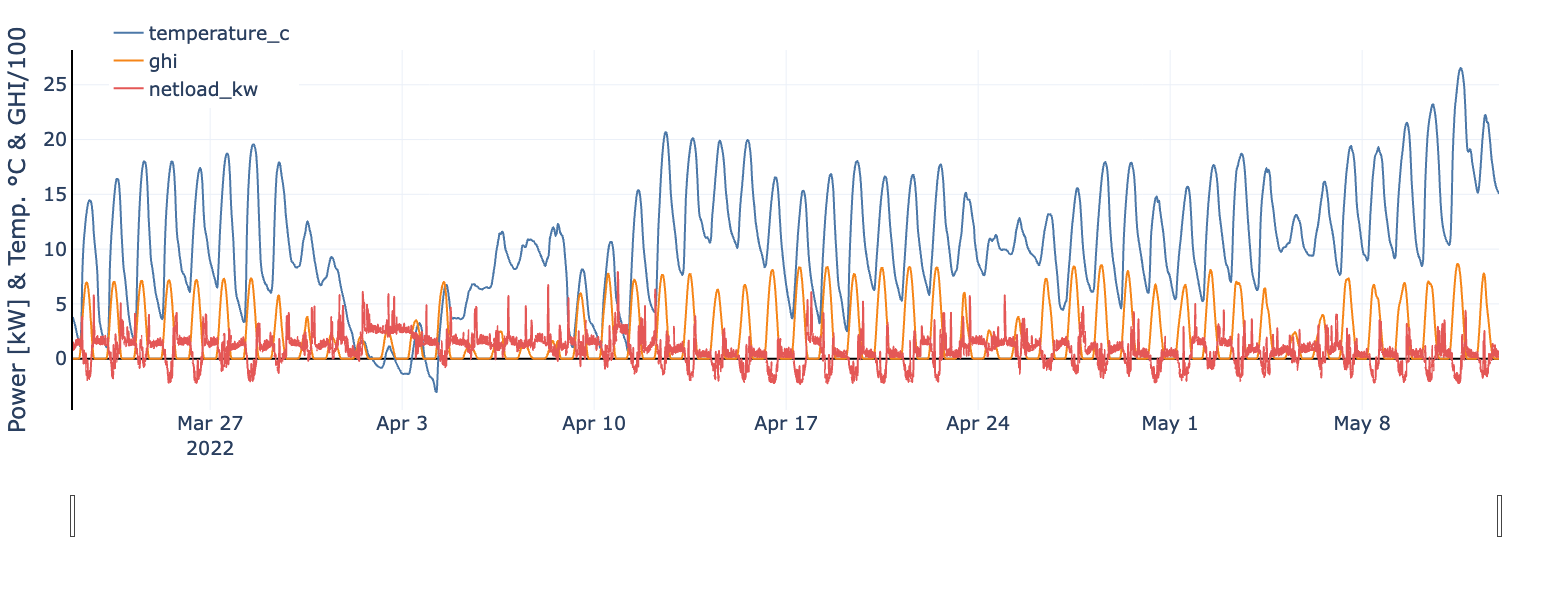

In [13]:
fig = px.line(df)
fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend={"x": 0.025, "y": 1.1},
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW] & Temp. °C & GHI/100",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0, xaxis_rangeslider_visible=True)
fig.show()

Both temperature and ghi do not have the noise of netload, so we probably won't capture it from those regressors.

# GAM (a.k.a. Prophet) model

In [77]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet


class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None, 
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0,
                 uncertainty_samples=False):
        self._output = output
        self._model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=uncertainty_samples,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(name=reg["name"], prior_scale=reg["prior_scale"])
        self.raw = pd.DataFrame()

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        self.raw = pd.concat([self.raw, forecast])
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


https://fr.mathworks.com/help/ident/ref/goodnessoffit.html

NRMSE express between 0% and 100%

In [49]:
def get_gof(df, result):
    pred = result.loc[:, ["netload_kw"]].copy()
    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], ["netload_kw"]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

$$gof = 1 - \frac{L_2(target_i - pred_i)}{L_2(target_i - mean(target_i))}$$

# No autoreggressors

In [16]:
def predict_n_periods_T(
    df, start_training, end_training, 
    horizon, deltat, nb_period, regressors=[],
    daily_seasonality="auto", seasonality_prior_scale=10.0):
    
    results = pd.DataFrame()
    inputs = [reg["name"] for reg in regressors]
    model = GAM("netload_kw", regressors, daily_seasonality, seasonality_prior_scale)
    model.fit(df.loc[start_training:end_training])
    start_prediction = end_training
    #print(f"Trained from {start_training.date()} to {end_training}")
    
    for i in range(0, nb_period):
        # Move delta after end last prediction/training
        start_prediction += deltat
        end_prediction = start_prediction + horizon
        
        res = model.predict(df.loc[start_prediction:end_prediction, inputs])
        results = pd.concat([results, res], axis=0)

        #print(f"Predicted from {start_prediction} to {end_prediction.time()}")
        start_prediction = end_prediction
    return results

# With autoreggressors

In [78]:
from tqdm.notebook import tqdm

def lag_values(df, nb_lag):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp["netload_kw"].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(
        df, start_training, end_training, horizon,
        deltat, nb_period, regressors=[], nb_lag=6,
        daily_seasonality="auto", seasonality_prior_scale=10.0,
        uncertainties=False):
    
    inputs = [reg["name"] for reg in regressors]
    results = pd.DataFrame()
    model = GAM("netload_kw", regressors, daily_seasonality, seasonality_prior_scale,
                uncertainty_samples=uncertainties)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag)
    model.fit(tmp.loc[start_training:end_training])
    start_prediction = end_training
    #print(f"Trained from {start_training.date()} to {end_training}")
    
    # Number of forecast where we have access to actual data
    for i in tqdm(range(0, nb_period), desc="# Forecast: "):
        start_prediction += deltat
        end_prediction = start_prediction + horizon
        
        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step in horizon_spam:
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.loc[step, f"t-{n}"]):
                    tmp.loc[step, f"t-{n}"] = results.loc[step-n*deltat, "netload_kw"]
            
            res = model.predict(tmp.loc[step:step, inputs])
            results = pd.concat([results, res], axis=0)
        
        #print(f"Predicted from {start_prediction} to {end_prediction.time()}")
        start_prediction = end_prediction
    return results, model

## Partial autocorrelation 

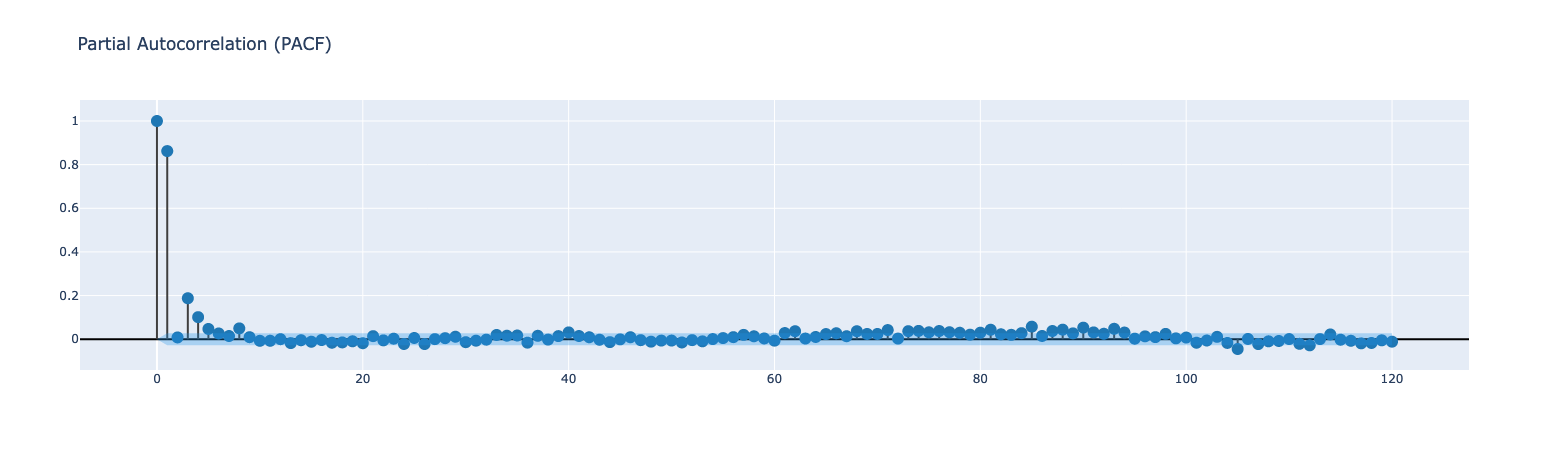

In [18]:
from statsmodels.tsa.stattools import pacf, acf
import plotly.graph_objects as go

def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05, nlags=30*4) if plot_pacf else acf(series.dropna(), alpha=0.05, nlags=30*4)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    #fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
create_corr_plot(df.netload_kw, plot_pacf=True)

## Transform netload data

Loïc: 
- décompose ta série en tendance, saison, et résidu. Utilise ARIMA, avec des régresseurs pour les saisons (projet Github?).
- Transforme le signal avec sklearn.preprocessing.PowerTransformer
- linky index comme régresseur
- forecast sur une semaine 

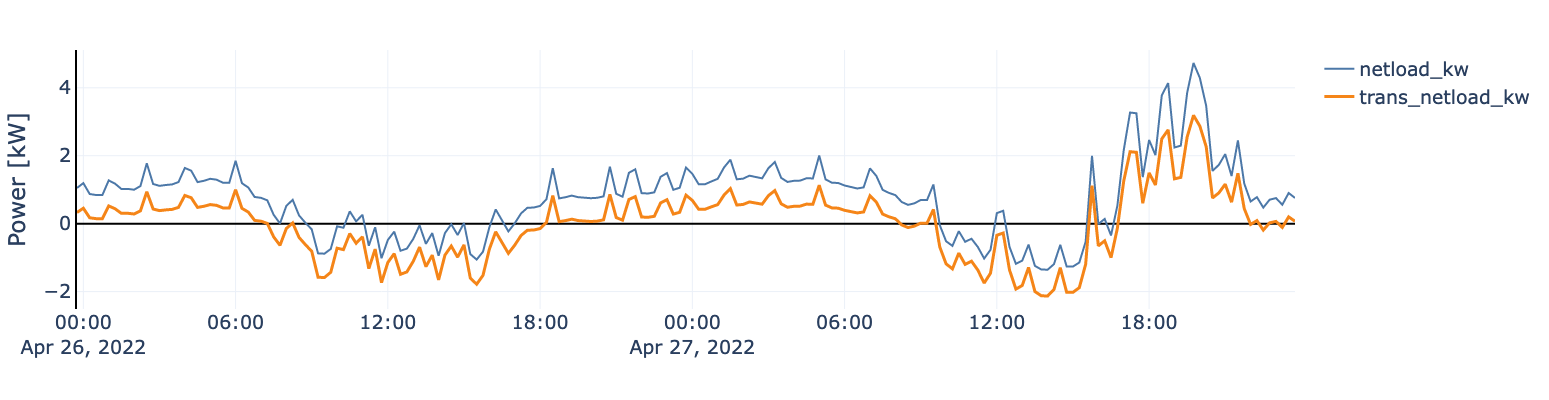

In [19]:
from sklearn.preprocessing import PowerTransformer

_start = datetime.fromisoformat("2022-04-25 23:45:00+00:00")
_end = _start + timedelta(days=2)

graph = df.loc[_start:_end, ["netload_kw"]]

pt = PowerTransformer()
graph["trans_netload_kw"] = pt.fit_transform(graph["netload_kw"].values.reshape(-1, 1))

fig = px.line(graph)
fig.data[-1].update(line_width=3, legendgroup=0)
fig.update_layout(
    layout,
    height=400,
    width=800,
    showlegend=True,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black'
)
fig.show()

# Parameters

# ---->

In [20]:
deltat = timedelta(minutes=15)
start_training = datetime.fromisoformat("2022-03-23 00:00:00+00:00")
end_training = datetime.fromisoformat("2022-04-25 23:45:00+00:00")
horizon = timedelta(hours=2, minutes=45)
one_step_in_horizon = int(horizon.total_seconds() / (15.0 * 60))
nb_period = 16

# ----->

In [21]:
regressor_prior_scale = 8.0
autoregressor_prior_scale = 10.0
seasonality_prior_scale = 1.0
daily_seasonality = "auto"

# Run comparison

## No regressors

In [50]:
pt = PowerTransformer()
graph = df.copy()
graph["netload_kw"] = pt.fit_transform(graph["netload_kw"].values.reshape(-1, 1))

results = predict_n_periods_T(graph, start_training, end_training, horizon, deltat, nb_period,
                              regressors=[],
                              seasonality_prior_scale=seasonality_prior_scale,
                              daily_seasonality=daily_seasonality)

results["netload_kw"] = pt.inverse_transform(results["netload_kw"].values.reshape(-1, 1))

gof = get_gof(df, results)

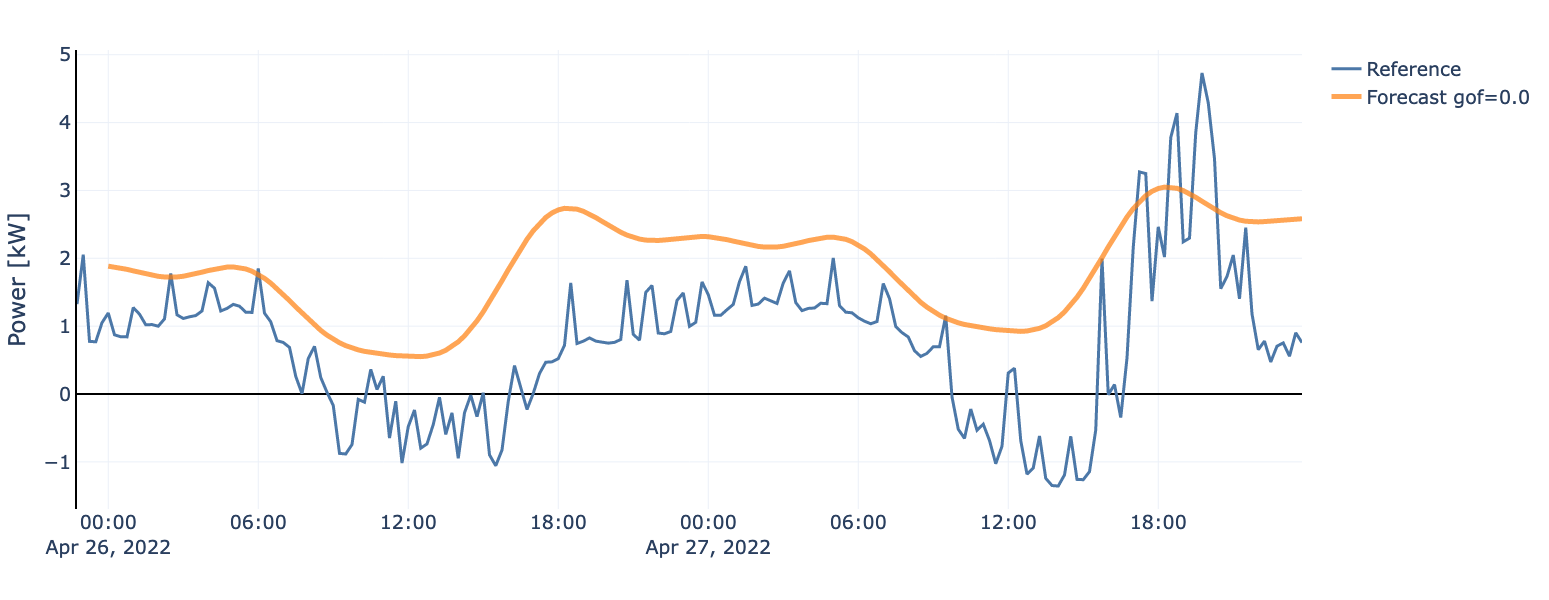

In [51]:
start = end_training
end = start + nb_period * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0)

for trace in px.line(results).data:
    fig.add_trace(trace)
    fig.data[-1].update(name=f"Forecast gof={np.round(gof, 2)}",
                        legendgroup=1,
                        line_width=5,
                        line_color="rgba(255, 127, 14, 0.7)")

fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black'
)
fig.show()

## With regressors

In [60]:
#pt = PowerTransformer()
#graph = df.copy()
#graph["netload_kw"] = pt.fit_transform(graph["netload_kw"].values.reshape(-1, 1))

graph = df.copy()
regressors = [#{"name": "temperature_c", "prior_scale": regressor_prior_scale},
              {"name": "ghi", "prior_scale": regressor_prior_scale}]

results = predict_n_periods_T(graph, start_training, end_training, horizon, deltat, nb_period, regressors,
                              seasonality_prior_scale=seasonality_prior_scale,
                              daily_seasonality=daily_seasonality)

#results["netload_kw"] = pt.inverse_transform(results["netload_kw"].values.reshape(-1, 1))

gof = get_gof(df, results)

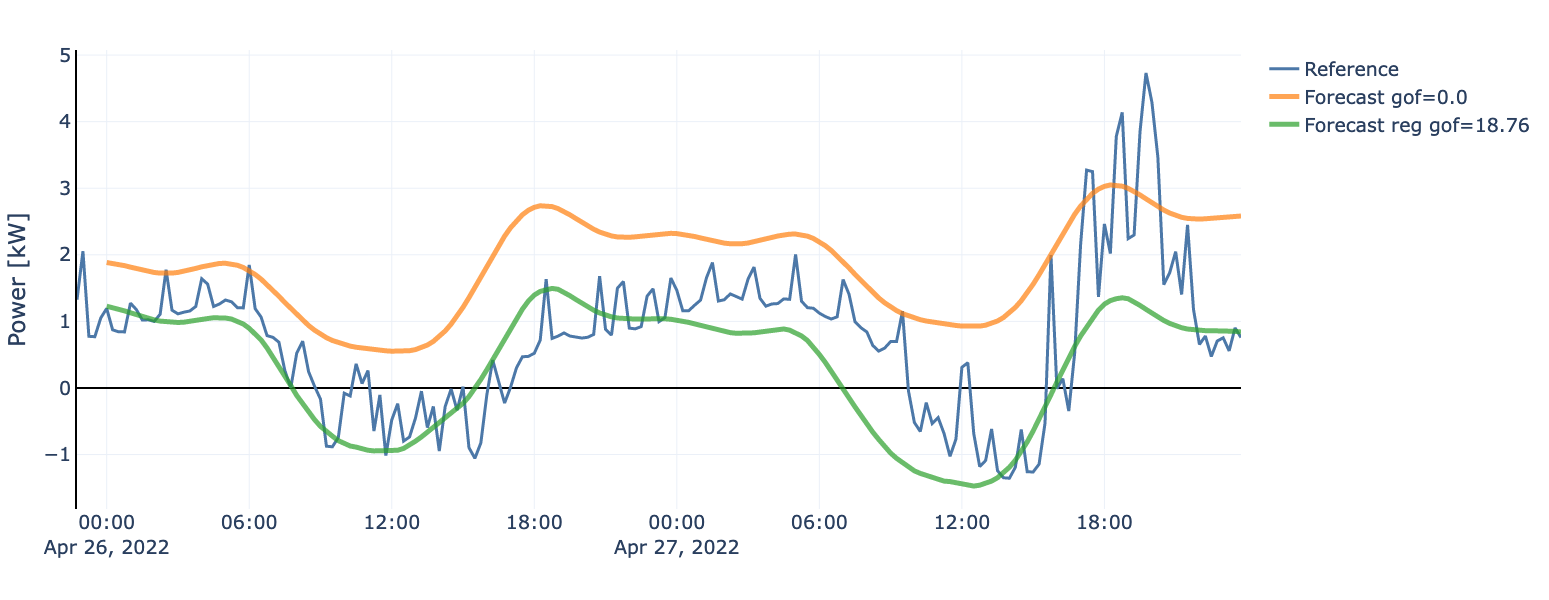

In [61]:
import plotly.graph_objects as go
_fig = go.Figure(fig)


for trace in px.line(results).data:
    _fig.add_trace(trace)
    _fig.data[-1].update(name=f"Forecast reg gof={np.round(gof, 2)}",
                         legendgroup=2,
                         line_width=5,
                         line_color="rgba(44, 160, 44, 0.7)")
_fig.show()

## Auto-regressors lagged

In [66]:
#pt = PowerTransformer()
graph = df.copy()
#graph["netload_kw"] = pt.fit_transform(graph["netload_kw"].values.reshape(-1, 1))

regressors = [#{"name": "temperature_c", "prior_scale": regressor_prior_scale},
              {"name": "ghi", "prior_scale": regressor_prior_scale}
]

nb_lag = list(range(1, 13))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": autoregressor_prior_scale})

results, _ = predict_n_periods_with_autoreg(
    graph, start_training, end_training, horizon, deltat, nb_period, regressors, 
    nb_lag=nb_lag,
    seasonality_prior_scale=seasonality_prior_scale,
    daily_seasonality=daily_seasonality)

#results["netload_kw"] = pt.inverse_transform(results["netload_kw"].values.reshape(-1, 1))

gof = get_gof(df, results)

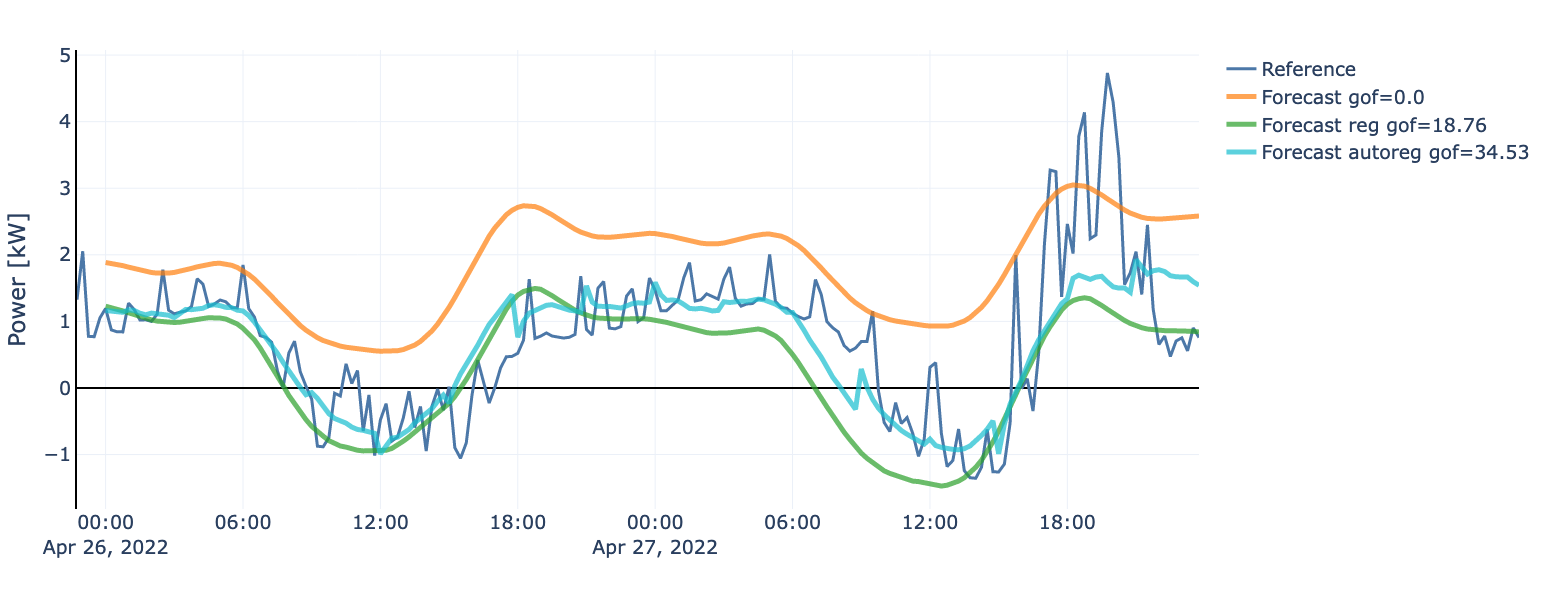

In [67]:
import plotly.graph_objects as go
__fig = go.Figure(_fig)

for trace in px.line(results).data:
    __fig.add_trace(trace)
    __fig.data[-1].update(name=f"Forecast autoreg gof={np.round(gof, 2)}",
                        line_width=5,
                        legendgroup=3,
                        line_color="rgba(23, 190, 207, 0.7)")

__fig.layout.update(xaxis_tickangle=0)
__fig.show()

In [28]:
__fig.write_image("results/forecasts.svg")

# With uncertainties

In [79]:
graph = df.copy()

regressors = [{"name": "ghi", "prior_scale": regressor_prior_scale}]
nb_lag = list(range(1, 13))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": autoregressor_prior_scale})

results, _ = predict_n_periods_with_autoreg(
    graph, start_training, end_training, 
    horizon, deltat, nb_period, regressors, 
    nb_lag=nb_lag,
    seasonality_prior_scale=seasonality_prior_scale,
    daily_seasonality=daily_seasonality,
    uncertainties=1000)

# Forecast:   0%|          | 0/16 [00:00<?, ?it/s]

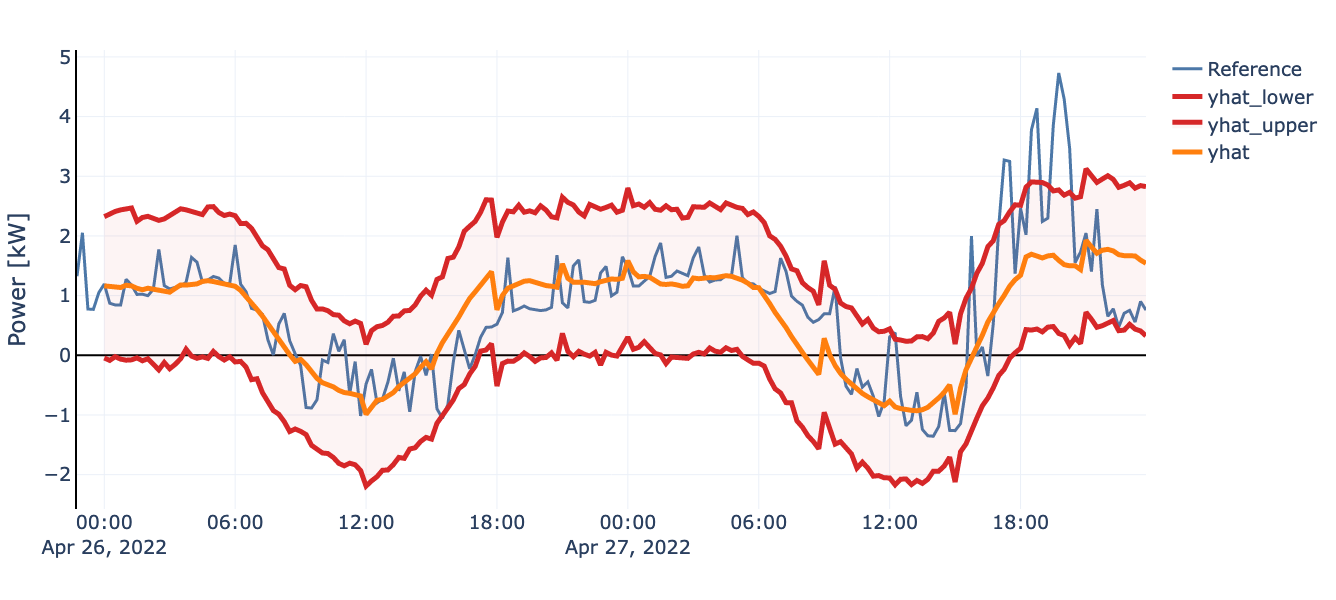

In [89]:
start = end_training
end = start + nb_period * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0)

graph = _.raw.copy()
graph.set_index("ds", inplace=True, drop=True)

colors = ["rgba(214, 39, 40, 1.0)", "rgba(214, 39, 40, 1.0)", "rgba(255, 127, 14, 1.0)"]
for i, trace in enumerate(px.line(graph[["yhat_lower", "yhat_upper", "yhat"]]).data):
    fig.add_trace(trace)
    fig.data[-1].update(line_width=5,
                        line_color=colors[i])

fig.data[-2].update(fill="tonexty", fillcolor="rgba(214, 39, 40, 0.05)")
    
fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black'
)
fig.show()

In [90]:
fig.write_image("results/uncertainties.svg")

# Number of lagged values

# Print components